In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

C:\Users\adhar\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\adhar\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
gen = Generator()
num_test = 100
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

In [4]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: 
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [5]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
num_test = 100
gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))
test_hidden_block = disc.make_disc_block(1,5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)
disc_output = disc(test_images)

In [6]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [7]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.9061002244949341, discriminator loss: 0.5115715696215635


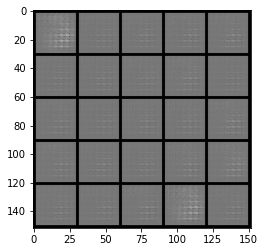

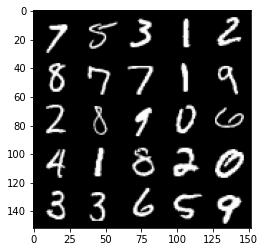

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 2.377919073343276, discriminator loss: 0.12786213204264646


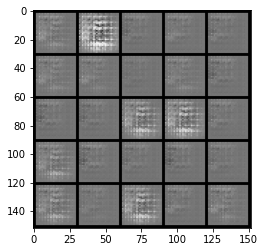

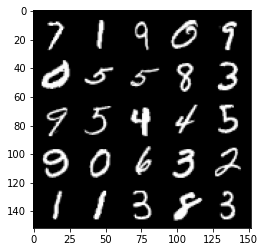

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 2.383322595596313, discriminator loss: 0.2626079487428069


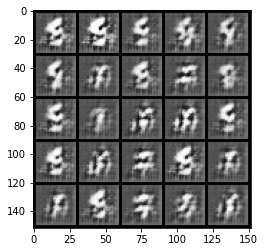

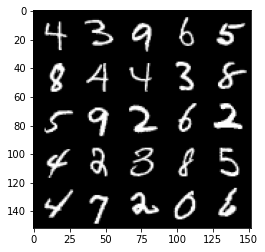

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.374739806190134, discriminator loss: 0.4731320329904555


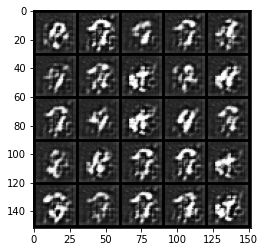

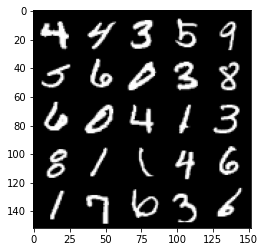

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.1555844313651318, discriminator loss: 0.5130141525268558


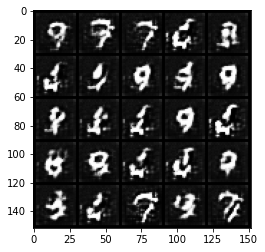

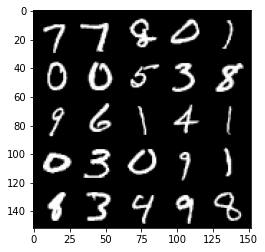

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.9621542002558708, discriminator loss: 0.5649020138978956


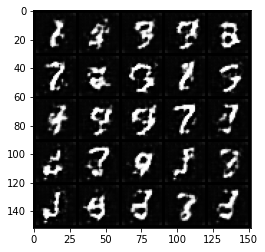

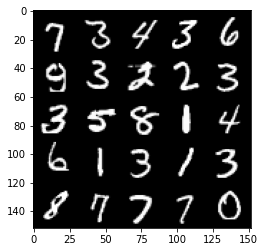

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.8891302118897448, discriminator loss: 0.6030677047967908


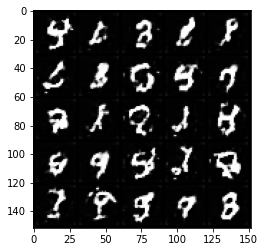

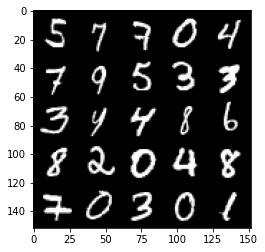

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.8480511202812206, discriminator loss: 0.6250627559423454


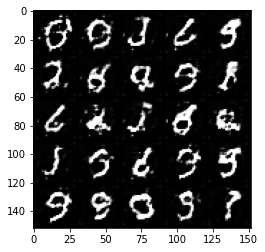

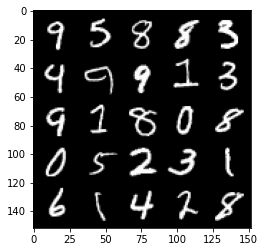

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.8294849375486374, discriminator loss: 0.6383625178337096


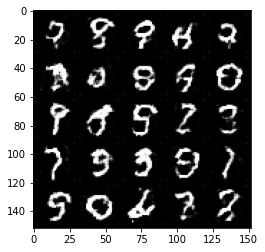

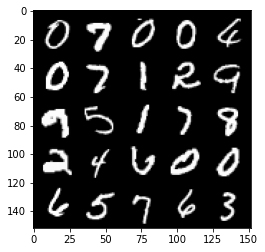

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.822348248422146, discriminator loss: 0.6435008802413941


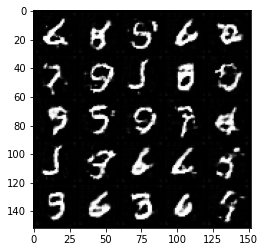

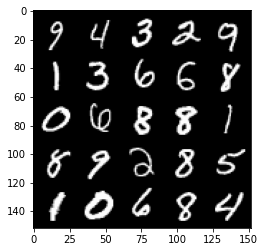

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.808282784819602, discriminator loss: 0.6474507261514664


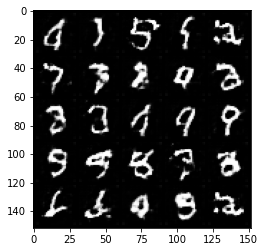

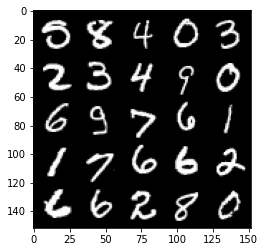

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.7944771176576618, discriminator loss: 0.6566542397737505


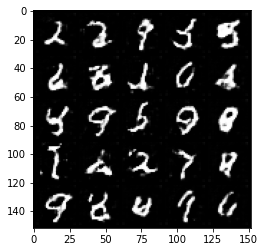

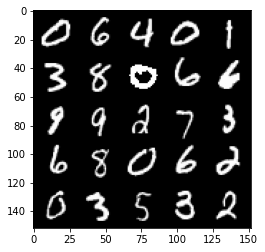

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.7890579232573497, discriminator loss: 0.6638436219692225


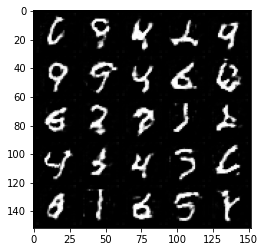

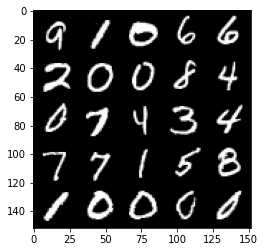

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.7788768158555033, discriminator loss: 0.666764314651489


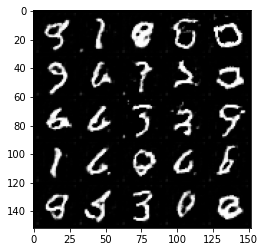

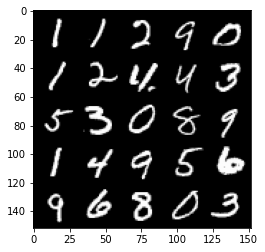

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.7788068152666102, discriminator loss: 0.6725724689960477


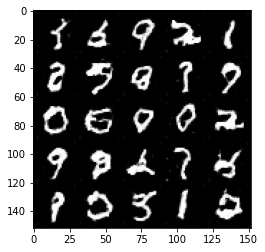

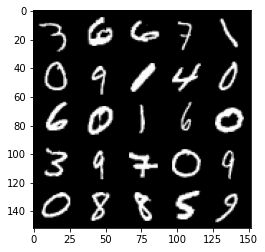

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.7688408817648882, discriminator loss: 0.6782549903392795


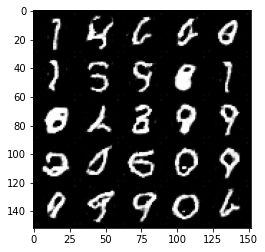

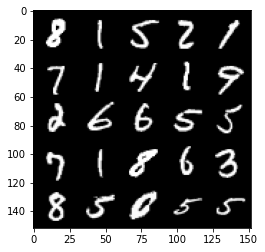

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.7580309348106389, discriminator loss: 0.6784680272340772


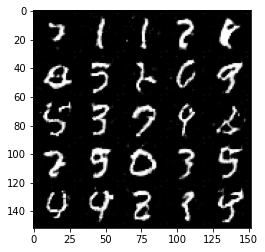

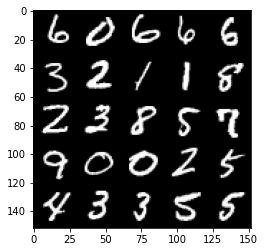

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.7526139712333677, discriminator loss: 0.6807058651447291


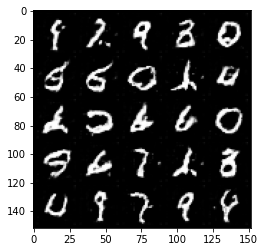

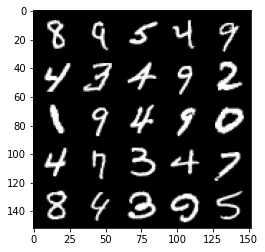

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.7496979734301563, discriminator loss: 0.6873893103599547


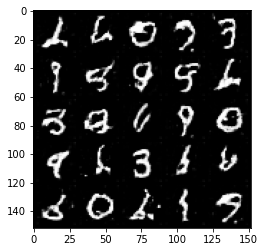

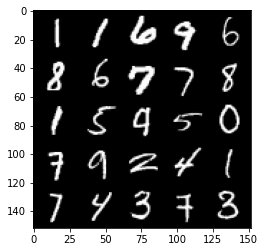

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.745916230499744, discriminator loss: 0.6910374677181238


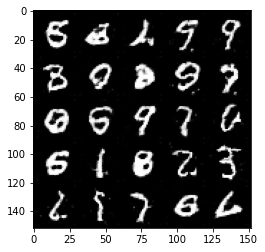

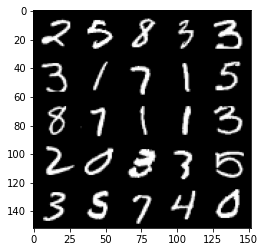

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.736711910009384, discriminator loss: 0.6908427367210385


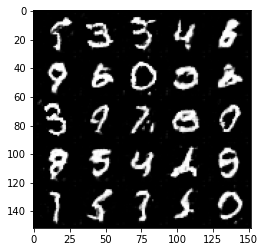

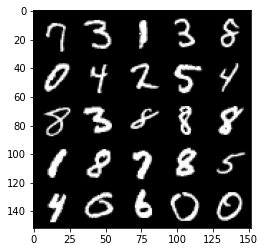

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.726355542838572, discriminator loss: 0.6941903060674661


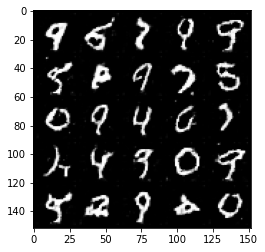

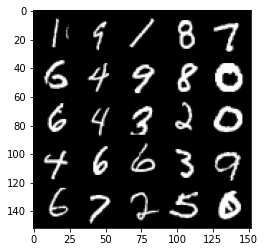

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 0.7247134890556335, discriminator loss: 0.6933079319000244


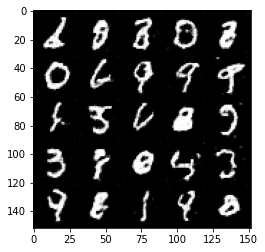

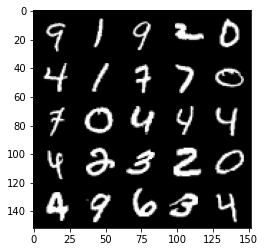

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.7267314854264255, discriminator loss: 0.6950681246519086


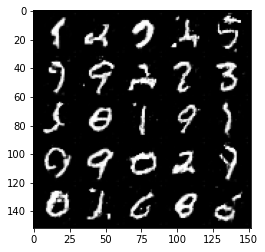

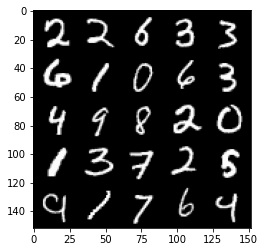

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 0.722955371558666, discriminator loss: 0.6970545053482057


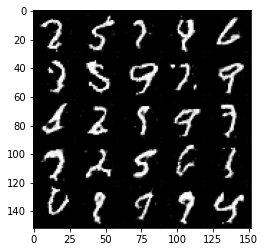

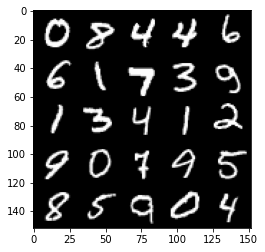

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.7186030495166768, discriminator loss: 0.6956627932786943


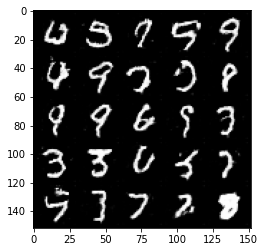

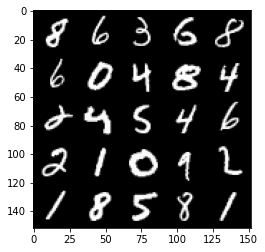

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 0.7162883919477462, discriminator loss: 0.6964228883981706


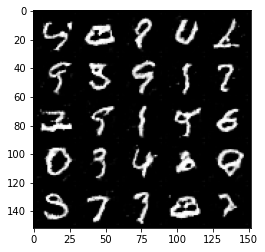

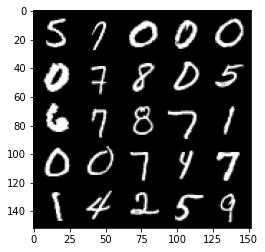

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.7100465652942647, discriminator loss: 0.6974286011457446


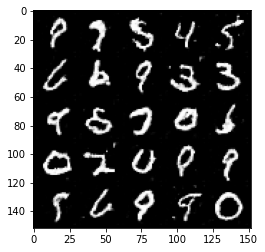

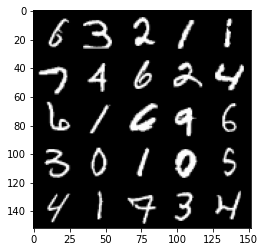

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 0.7138637573122985, discriminator loss: 0.6975773131847379


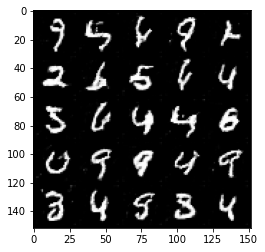

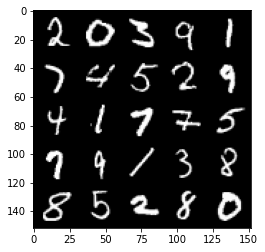

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.709966963529587, discriminator loss: 0.6985043495893489


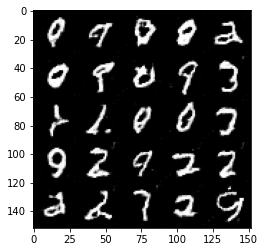

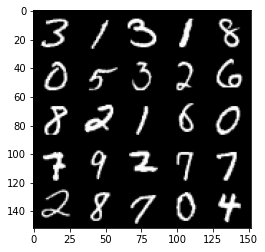

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 0.7094330854415888, discriminator loss: 0.6990698627233504


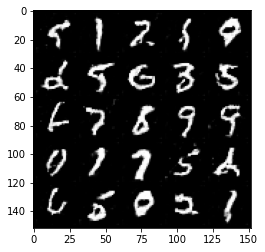

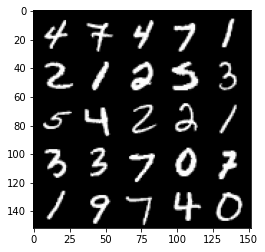

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.7078388246297833, discriminator loss: 0.699128422260284


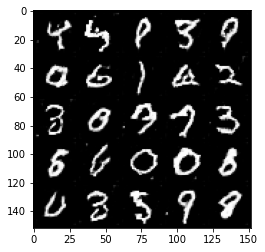

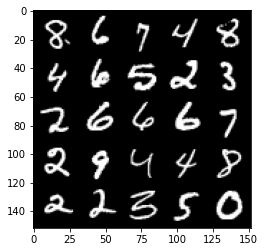

In [8]:
n_epochs = 35
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        mean_discriminator_loss += disc_loss.item() / display_step
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()
        mean_generator_loss += gen_loss.item() / display_step
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
